In [212]:
### Calculate (future) NSD from forecasts of a single intensity model using cyclone a-tracks
### Uses linear interpolation to get values of 6h intervals

# download latest a-tracks manually for basin of interest (no automation yet)
# and change names of atrack files below

# note: make sure to gunzip them
# https://ftp.nhc.noaa.gov/atcf/aid_public/?C=M;O=D
    
### DOWNLOAD LATEST ATRACKS AND UPDATE THE FOLLOWING TWO VARIABLES EVERY RUN OF THE NOTEBOOK
atrack_files = [
    'aal172023.dat'
]

# latest real time Named Storm Days (NSD) (for North Atlantic)
# from http://tropical.atmos.colostate.edu/Realtime/
# this includes the 1.25 NSD from January
real_time_NSD = 84.75

# Note: this auto-tunes an expotential decay parameter for expected NSD using MSE.
# Make sure to:
#   1) Check the difference of MSE in the validation
#   2) Check to make sure that the "Rate final tuning" is within the bounds of the rates tried

In [213]:
##### CONFIG BASIN AND INTENSITY MODEL
match_basin = 'AL'
# consensus model
match_model = 'IVCN'

In [214]:
ab_column_names = [
    'BASIN',
    'CY',
    'YYYYMMDDHH',
    'TECHNUM/MIN',
    'TECH',
    'TAU',
    'LatN/S',
    'LonE/W',
    'VMAX',
    'MSLP',
    'TY',
    'RAD',
    'WINDCODE',
    'RAD1',
    'RAD2',
    'RAD3',
    'RAD4',
    'POUTER',
    'ROUTER',
    'RMW',
    'GUSTS',
    'EYE',
    'SUBREGION',
    'MAXSEAS',
    'INITIALS',
    'DIR',
    'SPEED',
    'STORMNAME',
    'DEPTH',
    'SEAS',
    'SEASCODE',
    'SEAS1',
    'SEAS2',
    'SEAS3',
    'SEAS4',
    'USERDEFINED1',
    'userdata1',
    'USERDEFINED2',
    'userdata2',
    'USERDEFINED3',
    'userdata3',
    'USERDEFINED4',
    'userdata4',
    'USERDEFINED5',
    'userdata5'
]

In [215]:
import pandas as pd
from datetime import datetime

track_line_lists = []

# read the tracks
for atrack_file in atrack_files:
    with open(atrack_file, 'r') as file:
        lines = file.readlines()
    for line in lines:
        line_list = line.split(',')
        line_list_trim = [x.strip() for x in line_list]
        line_list_trim_rempty = line_list_trim
        
        # trim empty columns on right
        # a tracks have an extra comma before EOL for some reason (should have max 45 columns)
        line_list_trim_rempty.reverse()
        line_list_trim_empty = []
        for [i, v] in enumerate(line_list_trim_rempty):
            if v:
                line_list_trim_empty = line_list_trim_rempty[i:]
                break
        line_list_trim_empty.reverse()
        # convert init time strings to timestamp format
        line_list_trim_empty[2] = datetime.strptime(line_list_trim_empty[2], '%Y%m%d%H')
            
        track_line_lists.append(line_list_trim_empty)

In [216]:
# convert the line lists to a dataframe
df = pd.DataFrame(track_line_lists, columns=ab_column_names)

In [217]:
# get the last matching forecasts
df_match = df.loc[(df['BASIN'] == match_basin) & (df['TECH'] == match_model)]

newest_matching_cyclone_forecast_dfs = []
for cyclone_num in df_match['CY'].unique():
    df_cyclone = df_match.loc[(df['CY'] == cyclone_num)]
    newest_init_time = df_cyclone['YYYYMMDDHH'].max()
    newest_forecast = df_cyclone.loc[(df['YYYYMMDDHH'] == newest_init_time)]
    # make sure these columns are numeric
    # convert to numeric
    col_numeric_names = ["CY", "TAU", "VMAX", "MSLP"]
    for col_numeric_name in col_numeric_names:
        newest_forecast = newest_forecast.astype({col_numeric_name:'int'})
    # append to list of cyclone forecast dfs
    newest_matching_cyclone_forecast_dfs.append(newest_forecast)

In [218]:
import datetime as datetime
# interpolate to provide 06 taus
interp_intensity_cyclone_dfs = []

last_valid_time = None

for cyclone_df in newest_matching_cyclone_forecast_dfs:
    forecast_taus = cyclone_df['TAU'].unique()
    min_tau = forecast_taus.min()
    max_tau = forecast_taus.max()
    taus_6h = list(range(min_tau, max_tau + 6, 6))
    taus_missing = []
    for tau in taus_6h:
        if tau not in forecast_taus:
            taus_missing.append(tau)
    for missing_tau in taus_missing:
        # get prev tau
        prev_tau = missing_tau
        while prev_tau >= min_tau:
            prev_tau = prev_tau - 1
            if prev_tau in forecast_taus:
                break
        next_tau = missing_tau
        while next_tau <= max_tau:
            next_tau = next_tau + 1
            if next_tau in forecast_taus:
                break
        prev_intensity = cyclone_df.loc[(cyclone_df['TAU'] == prev_tau)]['VMAX'].values[0]
        next_intensity = cyclone_df.loc[(cyclone_df['TAU'] == next_tau)]['VMAX'].values[0]
        interpolated_intensity = int(round((prev_intensity + next_intensity) / 2.0))
        cyclone_df = cyclone_df.reset_index(drop=True)
        prev_idx = cyclone_df.loc[(cyclone_df['TAU'] == prev_tau)].index.values[0]
        # copy row
        interp_row = cyclone_df.iloc[prev_idx].copy()
        # only manipulate the TAU and INTENSITY so we don't have to copy the rest of the values
        # the long/lat and rest of data have not been interpolated....
        interp_row['TAU'] = missing_tau
        interp_row['VMAX'] = interpolated_intensity
        # add row
        #cyclone_df = cyclone_df.append(interp_row, ignore_index=True)
        cyclone_df = pd.concat([cyclone_df, pd.DataFrame([interp_row])], ignore_index=True)
    cyclone_df = cyclone_df.reset_index(drop=True)
    cyclone_df.sort_values(by=['TAU'], inplace=True)
    cyclone_df = cyclone_df.reset_index(drop=True)
    interp_intensity_cyclone_dfs.append(cyclone_df)
    # cyclone number
    cyclone_num = cyclone_df['CY'].iloc[-1]
    basin = cyclone_df.iloc[-1]['BASIN']
    init_time = cyclone_df.iloc[0]['YYYYMMDDHH']
    valid_time = init_time + datetime.timedelta(hours=int(max_tau))
    # print the forecast times
    print(f"{basin}{cyclone_num}: 0-{max_tau}H : {init_time} to {valid_time}")
    if last_valid_time == None:
        last_valid_time = valid_time
    if valid_time > last_valid_time:
        last_valid_time = valid_time

print("")
print("Longest forecast covers up until:", last_valid_time)

AL17: 0-84H : 2023-10-04 06:00:00 to 2023-10-07 18:00:00

Longest forecast covers up until: 2023-10-07 18:00:00


In [219]:
# exclude storms less than 35 kt
# exclude forecasts at 00h (since this may already be included in real time NSD)
NSD_min_kt = 35
storm_intensities_above_min = {}
for cyclone_df in interp_intensity_cyclone_dfs:
    cyclone_num = cyclone_df['CY'].iloc[-1]
    basin = cyclone_df.iloc[-1]['BASIN']
    storm_name_str = f'{basin}{cyclone_num}'
    min_kt_rows = cyclone_df.loc[(cyclone_df['VMAX'] >= NSD_min_kt) & (cyclone_df['TAU'] > 0)]['VMAX']
    storm_intensities_above_min[storm_name_str] = list(min_kt_rows.values)

In [220]:
import numpy as np
forecasts_NSD = {}
for [storm_name, vmax] in storm_intensities_above_min.items():
    # since there are 4 periods in each day they each account for 0.25 NSD
    forecast_storm_NSD = len(vmax) * 0.25
    forecasts_NSD[storm_name] = round(forecast_storm_NSD,2)

In [221]:
forecast_total_NSD = 0
print(f"Future contributions (up until {last_valid_time}) of NSD in {match_basin} basin (including INVESTs)\n",
      f"   from latest forecast using {match_model} (excluding 00h) by interpolating intensities")
for [storm_name, NSD] in forecasts_NSD.items():
    print(f"  NSD(future) for {storm_name} = {NSD}")
    forecast_total_NSD += NSD
print(f"  Total NSD(future): {forecast_total_NSD:4.2f}")
total_NSD_until_forecast = real_time_NSD + forecast_total_NSD
print("")
print("Real-time NSD:", real_time_NSD)
print(f"Total NSD (real-time + forecast) up until {last_valid_time}: {total_NSD_until_forecast:.2f}")

Future contributions (up until 2023-10-07 18:00:00) of NSD in AL basin (including INVESTs)
    from latest forecast using IVCN (excluding 00h) by interpolating intensities
  NSD(future) for AL17 = 3.5
  Total NSD(future): 3.50

Real-time NSD: 84.75
Total NSD (real-time + forecast) up until 2023-10-07 18:00:00: 88.25


In [222]:
print(storm_intensities_above_min)

{'AL17': [42, 43, 44, 44, 44, 43, 45, 47, 49, 51, 50, 50, 48, 47]}


In [223]:
print(interp_intensity_cyclone_dfs)

[   BASIN  CY          YYYYMMDDHH TECHNUM/MIN  TECH  TAU LatN/S LonE/W  VMAX  \
0     AL  17 2023-10-04 06:00:00          03  IVCN    0     0N     0W    40   
1     AL  17 2023-10-04 06:00:00          03  IVCN    6     0N     0W    42   
2     AL  17 2023-10-04 06:00:00          03  IVCN   12     0N     0W    43   
3     AL  17 2023-10-04 06:00:00          03  IVCN   18     0N     0W    44   
4     AL  17 2023-10-04 06:00:00          03  IVCN   24     0N     0W    44   
..   ...  ..                 ...         ...   ...  ...    ...    ...   ...   
10    AL  17 2023-10-04 06:00:00          03  IVCN   60     0N     0W    51   
11    AL  17 2023-10-04 06:00:00          03  IVCN   66     0N     0W    50   
12    AL  17 2023-10-04 06:00:00          03  IVCN   72     0N     0W    50   
13    AL  17 2023-10-04 06:00:00          03  IVCN   78     0N     0W    48   
14    AL  17 2023-10-04 06:00:00          03  IVCN   84     0N     0W    47   

    MSLP  ... USERDEFINED1 userdata1 USERDEFINED2 

In [224]:

import pandas as pd
import numpy as np
from datetime import datetime

# Define a function to convert the components into datetime objects
def convert_to_datetime(components, debug = False):
    # only use first time
    try:
        c = "".join(components.astype(str))
        year = int(c[0:4])
        month = int(c[5:7])
        day = int(c[8:10])
        hour = int(c[11:13])
        minute = int(c[14:16])
        second = int(c[17:])
        dt = datetime(year, month, day, hour, minute, second)
        return dt
    except:
        if debug:
            print("err")
            print(components)
        return None
    
def extract_first_num(components):
    try:
        return components[0].astype(int)
    except:
        return None

def extract_first_str(components):
    try:
        return "".join(components[0].astype(str))
    except:
        return None

def extract_first_byte(components):
    try:
        return "".join(components[0].astype(str))
    except:
        return None

In [225]:
# Calculate historical NSD energies from best tracks and use this to calculate expected NSD values from the above values

# from https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r00/access/csv/
best_tracks_csv = 'ibtracs.NA.list.v04r00.csv'

# Read the CSV file into a DataFrame without automatically assigning column names
df = pd.read_csv(best_tracks_csv, header=0, skiprows=[1], low_memory=False)


In [226]:
# Create a dictionary that specifies the data types for each column
dtype_mapping = {
    'LAT': float,
    'LON': float,
    'WMO_WIND': float,
    'WMO_PRES': float,
    'USA_WIND': float,
    'DIST2LAND': float,
    'LANDFALL': float,
    'STORM_SPEED': float,
    'STORM_DIR': float
}

# Apply dtype conversion to specific columns, treating non-numeric values as NaN
for column, data_type in dtype_mapping.items():
    df[column] = pd.to_numeric(df[column], errors='coerce').astype(data_type)

# convert time to datetime
df['ISO_TIME'] = pd.to_datetime(df['ISO_TIME'])


In [227]:

# Create a mask to filter the rows for only 6 hour times
mask = (df['ISO_TIME'].dt.hour.isin([0, 6, 12, 18])) & (df['ISO_TIME'].dt.minute == 0) & (df['ISO_TIME'].dt.second == 0)

# Apply the mask to filter the DataFrame
filtered_df = df[mask].copy()

# drop all but relevant column's for speed
selected_columns = ['SEASON', 'ISO_TIME', 'WMO_WIND', 'USA_WIND', 'NATURE', 'NAME', 'USA_STATUS', 'BASIN']
filtered_df = filtered_df[selected_columns]

In [228]:
#df_min_35kt = filtered_df.loc[(filtered_df['WMO_WIND'] >= 35) & ((filtered_df['NATURE'] == 'TS') & (filtered_df['NAME'] != 'NOT_NAMED'))]
pd.set_option('display.max_rows', 10)
df_min_35kt = filtered_df.loc[(filtered_df['USA_WIND'] >= 35) & (filtered_df['USA_STATUS'].isin(['TS', 'SS', 'HU', 'HR'])) & (filtered_df['BASIN'].isnull())]
df_min_35kt.reset_index()

,index,SEASON,ISO_TIME,WMO_WIND,USA_WIND,NATURE,NAME,USA_STATUS,BASIN
0,12,1851,1851-06-25 00:00:00,80.0,80.0,TS,NOT_NAMED,HU,NaN
1,14,1851,1851-06-25 06:00:00,80.0,80.0,TS,NOT_NAMED,HU,NaN
2,16,1851,1851-06-25 12:00:00,80.0,80.0,TS,NOT_NAMED,HU,NaN
3,18,1851,1851-06-25 18:00:00,80.0,80.0,TS,NOT_NAMED,HU,NaN
4,20,1851,1851-06-26 00:00:00,70.0,70.0,TS,NOT_NAMED,HU,NaN
...,...,...,...,...,...,...,...,...,...
35118,126552,2023,2023-09-16 06:00:00,NaN,55.0,TS,MARGOT,TS,NaN
35119,126554,2023,2023-09-16 12:00:00,NaN,45.0,TS,MARGOT,TS,NaN
35120,126556,2023,2023-09-16 18:00:00,NaN,45.0,TS,MARGOT,TS,NaN
35121,126558,2023,2023-09-17 00:00:00,NaN,40.0,TS,MARGOT,TS,NaN


In [229]:
#### if desired, use a manually specified time (must comment out the below line using last_valid_time)
NSD_time_end_str = "2023-09-24 06:00:00"
NSD_time = datetime.fromisoformat(NSD_time_end_str)

# otherwise, use the last valid_time
NSD_time = last_valid_time
####


# Calculate NSD for up to NSD_time_end_str for all years

NSD_time_month = NSD_time.month
NSD_time_day = NSD_time.day

season_NSD = {}
season_NSD_to_time_end = {}
season_NSD_above_real_time = {}

for idx in range(0, len(df_min_35kt)):
    r = df_min_35kt.iloc[idx]
    t = r['ISO_TIME']
    w = r['WMO_WIND']

years = list(set(list(df_min_35kt['SEASON'].values)))
    
for season in years:
    df_season_min_35kt = df_min_35kt.loc[(df_min_35kt['SEASON'] == season)]
    kts = list(df_season_min_35kt['WMO_WIND'].values)
    NSD = 0.25 * len(kts)
    season_NSD[season] = NSD
    
    # exclude NSD that are not representative for population statistics when they are below real time NSD
    if NSD >= real_time_NSD:
        season_NSD_above_real_time[season] = NSD
    
    # calculate NSD until NSD_time_end_str for each year
    df_season_to_time_end_min_35kt = df_season_min_35kt.loc[
        (df_season_min_35kt['ISO_TIME'].dt.month < NSD_time_month) | 
        (
            (df_season_min_35kt['ISO_TIME'].dt.month == NSD_time_month) &
            (df_season_min_35kt['ISO_TIME'].dt.day <= NSD_time_day)
        )
    ]
    kts = list(df_season_to_time_end_min_35kt['WMO_WIND'].values)
    NSD = 0.25 * len(kts)
    season_NSD_to_time_end[season] = NSD

print(f"Done calculating NSD for each year up until {last_valid_time.month}/{last_valid_time.day}")

Done calculating NSD for each year up until 10/7


In [230]:
# use this to normalize a 1-d array
def normalize(matrix):
    norm = np.linalg.norm(matrix, 1)
    matrix = matrix/norm 
    return matrix

# use exponential decay (the difference passed should always be positive)
def custom_kernel(difference, rate):
    #return (1.0 / difference)
    return np.exp(-rate * difference)

def get_min_pair_by_value(d):
    # Find the key/value pair with the minimum value from a dict
    return min(d.items(), key=lambda x: x[1])

def mean_squared_error(predictions, actual_values):
    # Ensure both dictionaries have the same keys
    common_keys = set(predictions.keys()) & set(actual_values.keys())
    
    # Calculate the squared differences and sum them
    squared_diff_sum = sum((predictions[key] - actual_values[key])**2 for key in common_keys)
    
    # Calculate the mean squared error
    mse = squared_diff_sum / len(common_keys)
    
    return mse

In [231]:
### This should be done regularly (after every day?) to get lower variance and proper decay values considering the time until to the end of the season

### TUNING & VALIDATION for decay rates and expected NSD (for this far out in year) ###

### do tuning on a partial dataset to calculate MSE and then do validation on the remaining dataset
### to make sure MSE is not too far off (this will be an estimate of the additional error/uncertainty in the tuning)

import random

years = list(season_NSD_to_time_end.keys())
years_above_real_time_NSD = sorted(list(season_NSD_above_real_time.keys()))

# Calculate the size of the first list (80%)
tuning_list_size = int(len(years) * 0.8)

# Randomly shuffle the original list
random.shuffle(years)

# Split the list into two new lists
years_tuning = years[:tuning_list_size]
years_validation = years[tuning_list_size:]
print(f"Tuning years: ", years_tuning)
print(f"Validation years: ", years_validation)

Tuning years:  [2017, 1911, 1943, 1976, 1944, 1988, 1919, 1920, 1955, 2012, 1934, 1980, 1996, 1897, 1883, 1948, 1957, 2020, 1945, 1853, 2018, 1938, 1875, 1914, 2007, 2021, 1965, 1987, 1974, 1907, 1995, 1878, 1954, 1859, 1946, 1968, 1866, 1896, 1900, 1927, 1876, 1851, 1940, 1993, 1933, 1992, 2005, 1942, 1912, 2014, 1983, 1862, 1874, 1860, 1882, 1991, 1950, 1865, 1977, 1923, 1906, 2004, 1892, 2011, 1869, 2016, 1985, 2010, 1921, 1961, 1922, 1904, 1939, 2003, 1889, 2002, 1913, 1852, 1989, 2008, 1947, 1885, 1856, 1868, 1879, 1863, 1884, 1962, 1998, 1905, 1959, 1937, 1861, 2006, 1975, 1899, 1971, 1932, 1972, 2022, 1951, 1973, 1978, 1888, 1958, 1857, 1909, 1864, 1970, 1931, 1924, 2023, 1881, 1935, 1872, 1893, 1952, 1960, 1871, 1918, 1854, 1891, 1966, 1997, 1949, 1855, 1895, 1956, 1898, 1887, 2000, 2009, 1990, 1908, 1936, 1902, 1903, 1894]
Validation years:  [2019, 1964, 1963, 1877, 1941, 1981, 2001, 1901, 1917, 1858, 1969, 1916, 1925, 1929, 2015, 1994, 1986, 1926, 1910, 1982, 1890, 2013, 1930

In [232]:
# exponential decay weights
#rates_to_try = list(np.round(np.arange(0.1, 0.5, 0.001),3))
rates_to_try = list(np.round(np.arange(0.1, 0.6, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_NSD_by_tuning_year = {}
    # tune over only years for validation set
    for tuning_year in years_tuning:
        # for tuning this is the season_NSD_to_time_end[tuning_year]
        tuning_NSD = season_NSD_to_time_end[tuning_year]

        tuning_diff_season_NSD_to_time_end = {}

        for [year, NSD] in season_NSD_to_time_end.items():
            if year in years_tuning and year != tuning_year:
                tuning_diff_season_NSD_to_time_end[year] = tuning_NSD - NSD

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in tuning_diff_season_NSD_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # Calculate expected NSD using normalized weights
        expected_NSD = 0.0
        for [x, year] in list(enumerate(tuning_diff_season_NSD_to_time_end)):
            expected_NSD += (weights_normalized[x] * season_NSD[year])
        #print(tuning_diff_season_NSD_to_time_end)

        expected_NSD_by_tuning_year[tuning_year] = expected_NSD
    
    # calculate the MSE for this rate
    #print(expected_NSD_by_tuning_year)
    mse = mean_squared_error(expected_NSD_by_tuning_year, season_NSD)
    mse_by_rate[rate] = mse

In [233]:
tuning_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Validation) Rate , MSE (minimum) for tuning dataset: {tuning_min_pair}")

(Validation) Rate , MSE (minimum) for tuning dataset: (0.379, 65.15680359351232)


In [234]:
# TUNING above has minimum MSE for:
# Rate: 0.14, MSE: 578.8630529802942

In [235]:
## VALIDATION
# exponential decay weights
rates_to_try = list(np.round(np.arange(0.05, 0.6, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_NSD_by_validation_year = {}
    for validation_year in years_validation:
        # for validation this is the season_NSD_to_time_end[validation_year]
        validation_NSD = season_NSD_to_time_end[validation_year]

        validation_diff_season_NSD_to_time_end = {}

        for [year, NSD] in season_NSD_to_time_end.items():
            if year in years_validation and year != validation_year:
                validation_diff_season_NSD_to_time_end[year] = validation_NSD - NSD

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in validation_diff_season_NSD_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # Calculate expected NSD using normalized weights
        expected_NSD = 0.0
        for [x, year] in list(enumerate(validation_diff_season_NSD_to_time_end)):
            expected_NSD += (weights_normalized[x] * season_NSD[year])
        #print(validation_diff_season_NSD_to_time_end)

        expected_NSD_by_validation_year[validation_year] = expected_NSD
    
    # calculate the MSE for this rate
    #print(expected_NSD_by_validation_year)
    mse = mean_squared_error(expected_NSD_by_validation_year, season_NSD)
    mse_by_rate[rate] = mse
    

In [236]:
validation_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Validation) Rate : MSE (minimum) for validation dataset: {validation_min_pair}")

(Validation) Rate : MSE (minimum) for validation dataset: (0.19, 73.03537170192867)


In [237]:
# for validation, the minimum MSE:
# Rate: 0.102, MSE: 439.9012525009955
# from the validation-tuning set above, the tuning Rate: 0.14, MSE: 450.0207460685012

rmse_tuning = pow(tuning_min_pair[1], 0.5)
rmse_validation = pow(validation_min_pair[1], 0.5)
diff_rmse = abs(rmse_tuning - rmse_validation)
print(f"RMSE tuning: {rmse_tuning:.2f}")
print(f"RMSE validation: {rmse_validation:.2f}")
print(f"Difference of RMSE(tuning) - RMSE(validation): {diff_rmse:.2f}")

RMSE tuning: 8.07
RMSE validation: 8.55
Difference of RMSE(tuning) - RMSE(validation): 0.47


In [238]:
# FINAL TUNING

# exponential decay weights
rates_to_try = list(np.round(np.arange(0.05, 0.6, 0.001),3))
#rates_to_try = [0.0001, 0.001, 0.01, 0.1, 1]
mse_by_rate = {}

# Calculate weights for each decay rate
for rate in rates_to_try:
    expected_NSD_by_tuning_year = {}
    # tune over all years
    for tuning_year in years:
        # for tuning this is the season_NSD_to_time_end[tuning_year]
        tuning_NSD = season_NSD_to_time_end[tuning_year]

        tuning_diff_season_NSD_to_time_end = {}

        for [year, NSD] in season_NSD_to_time_end.items():
            if year in years and year != tuning_year:
                tuning_diff_season_NSD_to_time_end[year] = tuning_NSD - NSD

        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in tuning_diff_season_NSD_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # Calculate expected NSD using normalized weights
        expected_NSD = 0.0
        for [x, year] in list(enumerate(tuning_diff_season_NSD_to_time_end)):
            expected_NSD += (weights_normalized[x] * season_NSD[year])
        #print(tuning_diff_season_NSD_to_time_end)

        expected_NSD_by_tuning_year[tuning_year] = expected_NSD
    
    # calculate the MSE for this rate
    #print(expected_NSD_by_tuning_year)
    mse = mean_squared_error(expected_NSD_by_tuning_year, season_NSD)
    mse_by_rate[rate] = mse
    #print(f"Rate: {rate}, MSE: {mse}")

final_tuning_min_pair = get_min_pair_by_value(mse_by_rate)
print(f"(Tuning Final) Rate : MSE (minimum) for all past years: {final_tuning_min_pair}")

(Tuning Final) Rate : MSE (minimum) for all past years: (0.36, 62.96792117167757)


In [239]:
# minimum is Rate: 0.147, MSE: 518.519969751831
mse_final_tuning = final_tuning_min_pair[1]
rate_final_tuning = final_tuning_min_pair[0]
print(f"Rate final tuning: {rate_final_tuning:0.4f}")
print(f"MSE final tuning: {mse_final_tuning:.2f}")
rmse_final_tuning = pow(mse_final_tuning,0.5)
print("")
print(f"RMSE final tuning: {rmse_final_tuning:.2f}")

Rate final tuning: 0.3600
MSE final tuning: 62.97

RMSE final tuning: 7.94


In [247]:
def calculate_expected_NSD(this_season_end = season_NSD_to_time_end, repeat_counts = None):
    diff_season_NSD_to_time_end = {}
    for [year, NSD] in this_season_end.items():
        diff_season_NSD_to_time_end[year] = present_NSD - NSD

    # exponential decay weights
    #rates_to_try = list(np.round(np.arange(0.080, 0.205, 0.005),3))
    rates_to_try = [rate_final_tuning]

    expected_NSD_by_rate = {}
    weights_normalized_by_year = {}
    # Calculate weights for each decay rate
    for rate in rates_to_try:
        # Calculate weights for each year
        weights_normalized = []
        weights = []
        for [year, diff] in diff_season_NSD_to_time_end.items():        
            # Calculate weights using the custom kernel function
            weight = custom_kernel(np.abs(diff), rate)
            weights.append(weight)

        # Calculate the normalized weights
        weights_normalized = normalize(weights)

        # store weights by year for useful statistics
        weights_normalized_by_year = {}

        weights_total = 0.0
        # Calculate expected NSD using normalized weights
        expected_NSD = 0.0
        for [x, year] in list(enumerate(diff_season_NSD_to_time_end)):
            weights_normalized_by_year[year] = weights_normalized[x]
            if repeat_counts:
                repeat_count = repeat_counts[year]
                # can't just multiply by repeat_count without renormalizing
                expected_NSD += (repeat_count * (weights_normalized[x] * season_NSD[year]))
                weights_total += repeat_count * weights_normalized[x]
            else:
                expected_NSD += (weights_normalized[x] * season_NSD[year])
                weights_total += weights_normalized[x]

        # renormalize (only affected if repeat_counts is set)
        expected_NSD_by_rate[rate] = expected_NSD / weights_total

    expected_NSD = expected_NSD_by_rate[rate_final_tuning]

    return [expected_NSD, weights_normalized_by_year]


Forecasts until: 2023-10-07 18:00:00
NSD, Real-time + storm model forecast: 88.2
Tuned decay rate: 0.36

Expected NSD (weight historical NSD using exponential decay): 107.36


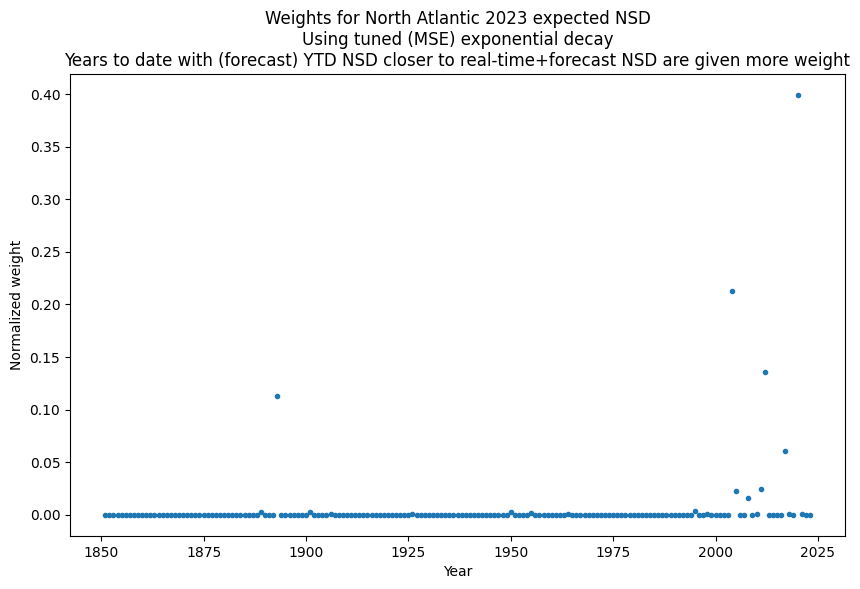

Top 10 weights (sorted by weight)
----------------------------------------
Rank  |  Year  |  Weight  |  Season NSD
----------------------------------------
   1  |  2020  |  0.399   |  122.75
   2  |  2004  |  0.213   |  93.00
   3  |  2012  |  0.136   |  101.25
   4  |  1893  |  0.113   |  98.75
   5  |  2017  |  0.060   |  93.00
   6  |  2011  |  0.025   |  89.75
   7  |  2005  |  0.022   |  131.50
   8  |  2008  |  0.016   |  88.25
   9  |  1995  |  0.003   |  120.50
  10  |  1901  |  0.003   |  85.75


In [248]:
from scipy.stats import norm
from collections import Counter
import matplotlib.pyplot as plt

# real-time NSD plus forecast NSD (until NSD_time_end_str)
# use a manually entered value
present_NSD = 122.65
# or the value from the forecast
present_NSD = total_NSD_until_forecast
####################################

[expected_NSD, weights_normalized_by_year] = calculate_expected_NSD()
    
pop_NSD_values = list(season_NSD_above_real_time.values())
n_pop_NSD_values = len(pop_NSD_values)
NSD_stddev = np.std(pop_NSD_values)
NSD_mean = np.mean(pop_NSD_values)
NSD_median = np.median(pop_NSD_values)
z_score = (expected_NSD - NSD_mean) / NSD_stddev

sorted_years = sorted(years)

print(f"Forecasts until:", last_valid_time)
print(f"NSD, Real-time + storm model forecast: {total_NSD_until_forecast:3.1f}")
print("Tuned decay rate:", rate_final_tuning)
print("")
print(f"Expected NSD (weight historical NSD using exponential decay): {expected_NSD:3.2f}")

expected_NSD_years = list(weights_normalized_by_year.keys())
expected_NSD_weights = list(weights_normalized_by_year.values())

# Plot the values of the weights
plt.figure(figsize=(10, 6))
plt.plot(expected_NSD_years, expected_NSD_weights, marker='.', linestyle='')
plt.xlabel('Year')
plt.ylabel('Normalized weight')
plt.title('Weights for North Atlantic 2023 expected NSD\nUsing tuned (MSE) exponential decay\nYears to date with (forecast) YTD NSD closer to real-time+forecast NSD are given more weight')
plt.show()

# Print out the ranking of weights
num_weights_in_table = 10

# Sort the dictionary items by values in descending order
sorted_weights_by_year = dict(
    sorted(weights_normalized_by_year.items(), key=lambda x: float(x[1]), reverse=True)[:num_weights_in_table]
)

# Convert NumPy values to regular Python types
sorted_weights_by_year = {int(year): float(weight) for year, weight in sorted_weights_by_year.items()}

# Print the table header
print(f"Top {num_weights_in_table} weights (sorted by weight)")
print("-" * 40)
print("Rank  |  Year  |  Weight  |  Season NSD")
print("-" * 40)

# Iterate through the first X items and print the rank, year, and weight
for rank, (year, weight) in enumerate(sorted_weights_by_year.items(), start=1):
    print(f"{rank:4}  |  {year:4}  |  {weight:.3f}   |  {season_NSD[year]:3.2f}")


NSD 101.5 (exp. decay) %: 26.68 %


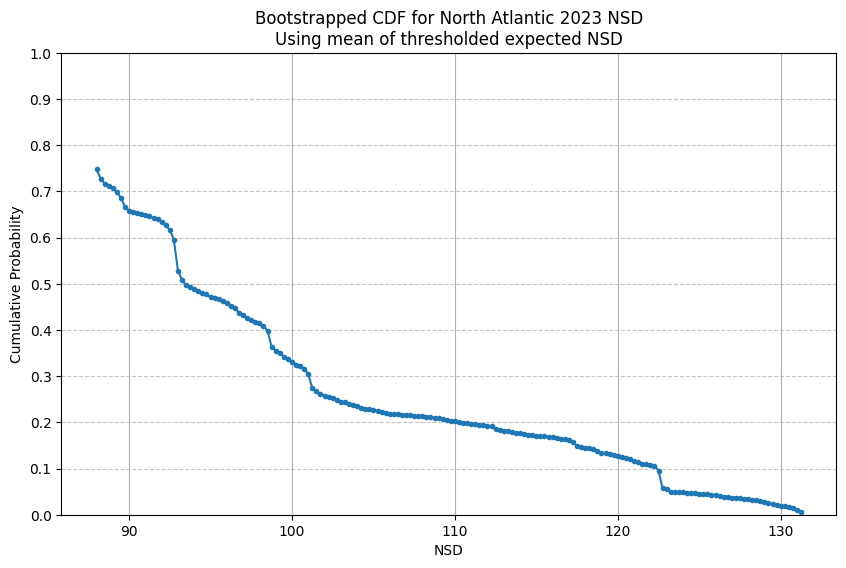


NSD 101.5 (excluding years below real-time NSD) %: 1.84 %


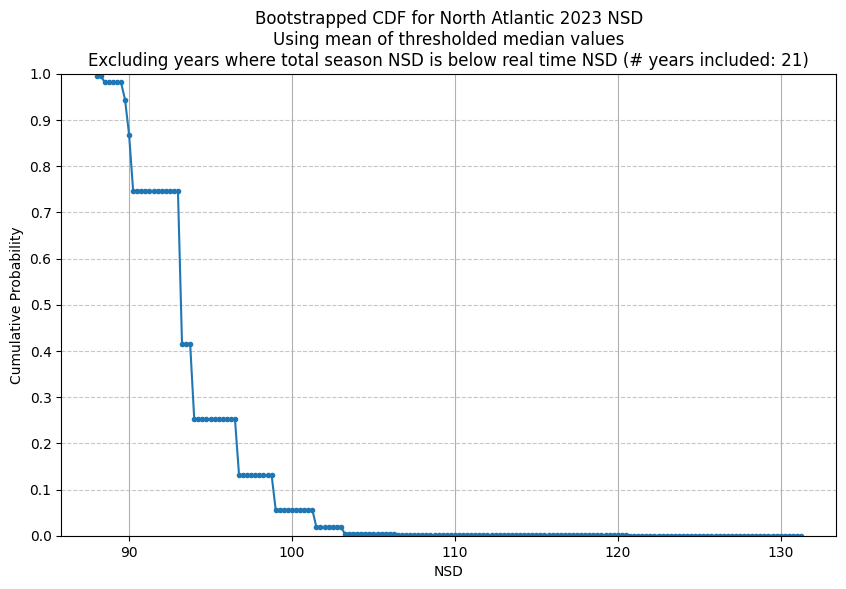


% chance of NSD=101.5 using average of two probabilities: 14.26%

Statistics for 1851 - 2023 excluding years with season NSD < realtime NSD:
μ: 98.80
median: 93.00



In [242]:
# Specify the confidence level (e.g., 90% CI)
confidence_level = 0.7

# use bootstrapping instead for CI

# Number of bootstrap samples to generate
num_samples = 100000

# Calculate the statistic of interest (e.g., mean) for the original data
original_statistic = expected_NSD

# Initialize an array to store resampled statistics
resampled_statistics = np.empty(num_samples)

# Range of values for CDF estimation
#values_of_interest = list(range(round(present_NSD), round(max(pop_NSD_values)), 1))
values_of_interest = list(np.round(np.arange(round(present_NSD), np.round(max(pop_NSD_values),2), 0.25),2))

# store when the median is greater than each value of interest
binary_outcomes = np.empty((num_samples, len(values_of_interest)))

# Perform bootstrapping
for i in range(num_samples):
    # Generate a resampled dataset by sampling with replacement
    
    # cannot do random choice on a dict...
    #resampled_data = np.random.choice(season_NSD_above_real_time, size=len(season_NSD_above_real_time), replace=True)
    
    num_sample_years = len(season_NSD_above_real_time)  # Number of samples you want to draw
    # Randomly select keys from the dictionary with replacement
    random_keys = random.choices(list(season_NSD_to_time_end.keys()), k=num_sample_years)
    # Use the selected keys to access corresponding values
    random_values = [season_NSD_to_time_end[key] for key in random_keys]
    
    # since I need to pass a dict that should have multiple keys repeated, do something extra to keep track of the 'repeats'
    repeat_counts = dict(Counter(random_keys))
    
    resampled_data = {key: value for key, value in zip(random_keys, random_values)}
    
    # Calculate the statistic of interest for the resampled dataset
    [resampled_statistic, weights_normalized_by_year] = calculate_expected_NSD(resampled_data, repeat_counts)
    
    # Store the resampled statistic
    resampled_statistics[i] = resampled_statistic
    
    # Threshold on the values of interest using the expected NSD
    binary_outcome = []
    for value in values_of_interest:
        if resampled_statistic < value:
            binary_outcome.append(0)
        else:
            binary_outcome.append(1)
    binary_outcomes[i] = binary_outcome
    
# Calculate the CDF for each value of interest (using the average of the thresholded binary outcomes)
cdf = np.mean(binary_outcomes, axis=0)

print("")
print(f"NSD 101.5 (exp. decay) %: {cdf[values_of_interest.index(101.5)]*100:2.2f} %")
prob_exp = cdf[values_of_interest.index(101.5)]


# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(values_of_interest, cdf, marker='.', linestyle='-')
plt.xlabel('NSD')
plt.ylabel('Cumulative Probability')
plt.title('Bootstrapped CDF for North Atlantic 2023 NSD\nUsing mean of thresholded expected NSD')

# Set y-axis limits to 0.0 and 1.0
plt.ylim(0.0, 1.0)

# Customize y-axis ticks and grid lines at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)
plt.grid(True)
plt.show()

# Calculate the lower and upper bounds of the confidence interval
alpha = 1 - confidence_level
lower_bound = np.percentile(resampled_statistics, 100 * alpha / 2)
upper_bound = np.percentile(resampled_statistics, 100 * (1 - alpha / 2))

# Print the results
#print(f"(bootstrapped) CI using expected value ({confidence_level*100:2.1f}%): [{lower_bound:3.2f}, {upper_bound:3.2f}]")

# use bootstrapping instead for CI

# Number of bootstrap samples to generate
num_samples = 100000

# Calculate the statistic of interest (e.g., mean) for the original data
original_statistic = NSD_median

# Initialize an array to store resampled statistics
resampled_statistics = np.empty(num_samples)

# Range of values for CDF estimation
#values_of_interest = list(range(round(present_NSD), round(max(pop_NSD_values)), 1))
values_of_interest = list(np.round(np.arange(round(present_NSD), np.round(max(pop_NSD_values), 2), 0.25), 2))

# Initialize an array to store CDF from bootstraps
binary_outcomes = np.empty((num_samples, len(values_of_interest)))

# Perform bootstrapping
for i in range(num_samples):
    # Generate a resampled dataset by sampling with replacement
    resampled_data = np.random.choice(pop_NSD_values, size=len(pop_NSD_values), replace=True)
    
    # Calculate the statistic of interest for the resampled dataset
    resampled_statistic = np.median(resampled_data)
    
    # Store the resampled statistic
    resampled_statistics[i] = resampled_statistic

    # Threshold on the values of interest using the expected NSD
    binary_outcome = []
    for value in values_of_interest:
        if resampled_statistic < value:
            binary_outcome.append(0)
        else:
            binary_outcome.append(1)
    binary_outcomes[i] = binary_outcome
    
# Calculate the CDF for each value of interest (using the average of the thresholded binary outcomes)
cdf = np.mean(binary_outcomes, axis=0)
print("")
print(f"NSD 101.5 (excluding years below real-time NSD) %: {cdf[values_of_interest.index(101.5)]*100:2.2f} %")
prob_realtime = cdf[values_of_interest.index(101.5)]

# Plot the CDF
plt.figure(figsize=(10, 6))
plt.plot(values_of_interest, cdf, marker='.', linestyle='-')

plt.xlabel('NSD')
plt.ylabel('Cumulative Probability')
plt.title(f'Bootstrapped CDF for North Atlantic 2023 NSD\nUsing mean of thresholded median values\nExcluding years where total season NSD is below real time NSD (# years included: {n_pop_NSD_values})')

# Set y-axis limits to 0.0 and 1.0
plt.ylim(0.0, 1.0)

# Customize y-axis ticks and grid lines at intervals of 0.1
plt.yticks(np.arange(0, 1.1, 0.1))
plt.gca().yaxis.grid(True, linestyle='--', alpha=0.7)

plt.grid(True)
plt.show()
    
# not useful with long tail
# Specify the confidence level (e.g., 90% CI)
confidence_level = 0.54

# Calculate the lower and upper bounds of the confidence interval
alpha = 1 - confidence_level
lower_bound = np.percentile(resampled_statistics, 100 * alpha / 2)
upper_bound = np.percentile(resampled_statistics, 100 * (1 - alpha / 2))


# Print the results
#print(f"(bootstrapped) CI using median ({confidence_level*100:2.1f}%): [{lower_bound:3.2f}, {upper_bound:3.2f}]")
print("")
avg_of_two_at_101_5 = (prob_realtime + prob_exp) / 2
print(f"% chance of NSD=101.5 using average of two probabilities: {avg_of_two_at_101_5*100:2.2f}%")

print("")
print(f"Statistics for {sorted_years[0]} - {sorted_years[-1]} excluding years with season NSD < realtime NSD:")
print(f"μ: {NSD_mean:3.2f}")
print(f"median: {NSD_median:3.2f}")

# not as useful since it doesn't handle constraints well so don't use general statistics below for CI:
#print("σ:", NSD_stddev)
#print("Z score for expected NSD:", z_score)
#ci_lower = expected_NSD - (critical_value * NSD_stddev)
#ci_upper = expected_NSD + (critical_value * NSD_stddev)
#print(f"CI({confidence_level}) = [ {ci_lower} , {ci_upper} ]")


# expect the tuned decay rate should automatically increase as the season passes
#   this means, later in the season it will be more selective in using years that have NSD that are very close to the present
#   as opposed to early in the season when the years will be more of an average
# for instance on Sept 24 06Z it was 0.147, and on Sept 25 00Z it was 0.171
print("")

# diagnostics for model predictiveness as the season progresses
expected_NSD_upper = expected_NSD + rmse_final_tuning
expected_NSD_lower = expected_NSD - rmse_final_tuning
#print(f"Range using RMSE (without validation RMSE): {expected_NSD_lower} : {expected_NSD_upper}")
expected_NSD_upper_with_validation = expected_NSD + rmse_final_tuning + diff_rmse
expected_NSD_lower_with_validation = expected_NSD - rmse_final_tuning - diff_rmse
#print(f"Range using RMSE (with validation RMSE):    {expected_NSD_lower_with_validation} : {expected_NSD_upper_with_validation}")

In [243]:
with open('season_NSD.csv', 'w') as file:
    for [year,nsd] in season_NSD.items():
        file.write(f"{year}, {nsd}\n")